# Baseline LEO DQN

Determining observation and action space dimensions from LEO env...
Detected obs_dim=12, act_dim=4

Initializing DQN agent for single LEO task (Obs: 12, Act: 4)...
Creating fixed LEO environment for DQN training...
Episode 10/250 | Reward: 25.88 | Avg Loss: 0.0115 (std: 0.0115) | Epsilon: 0.91 | Action Dist (avg over 10 eps): [14.2  9.8 11.  12.7]
Episode 20/250 | Reward: 38.89 | Avg Loss: 0.0070 (std: 0.0070) | Epsilon: 0.83 | Action Dist (avg over 10 eps): [16.7 11.1  9.8 10.4]
Episode 30/250 | Reward: 48.87 | Avg Loss: 0.0049 (std: 0.0049) | Epsilon: 0.76 | Action Dist (avg over 10 eps): [19.6  9.2  8.7 10.5]
Episode 40/250 | Reward: 45.08 | Avg Loss: 0.0226 (std: 0.0226) | Epsilon: 0.69 | Action Dist (avg over 10 eps): [20.9  8.5  7.6  9.2]
Episode 50/250 | Reward: 43.81 | Avg Loss: 0.0263 (std: 0.0263) | Epsilon: 0.63 | Action Dist (avg over 10 eps): [24.1  8.9  7.9  7. ]
Episode 60/250 | Reward: 35.08 | Avg Loss: 0.0186 (std: 0.0186) | Epsilon: 0.57 | Action Dist (avg over 10 eps

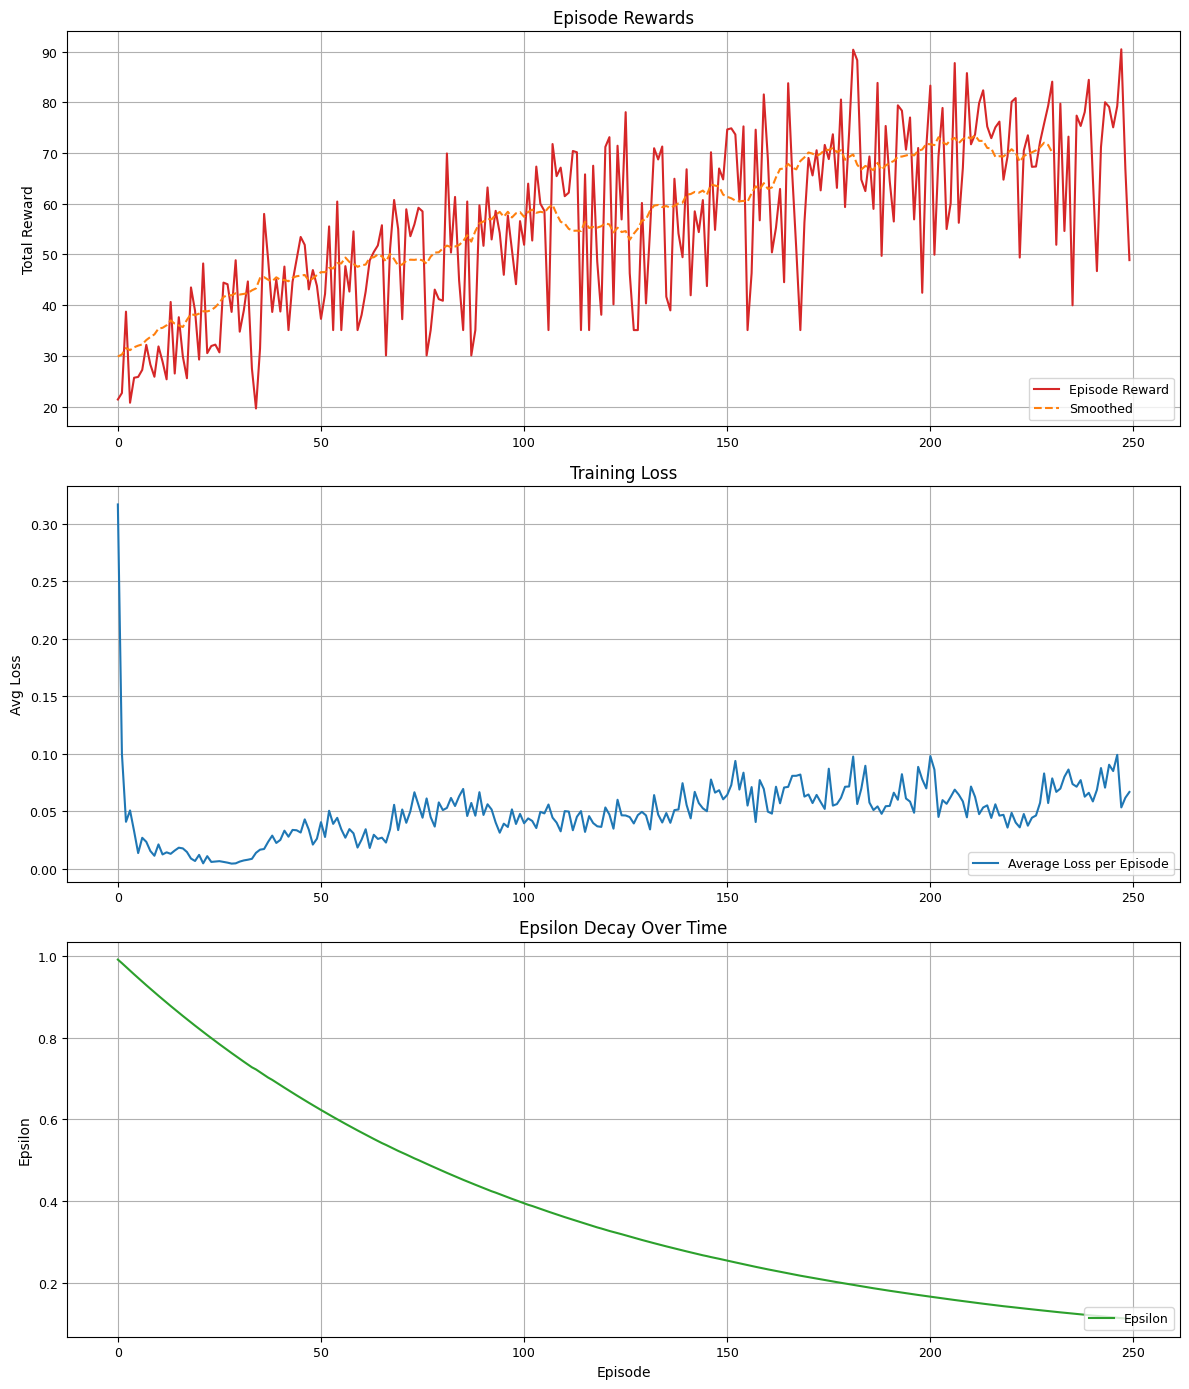

Saved enhanced training diagnostics to 'dqn_training_diagnostics.png'


In [1]:
# === Imports ===
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque, namedtuple
import copy
import os
import matplotlib.pyplot as plt

# BSK imports 
from bsk_rl.sim.world import BasicWorldModel, GroundStationWorldModel
from Basilisk.utilities import simIncludeGravBody, orbitalMotion
from bsk_rl.sats.satellite import Satellite
from bsk_rl.obs.observations import SatProperties, Eclipse, Time
from bsk_rl.act.discrete_actions import Scan, Charge, Downlink, Desat
from bsk_rl.sim.fsw import ContinuousImagingFSWModel
from bsk_rl.data import ScanningTimeReward
from bsk_rl.sim import dyn
from bsk_rl.utils.functional import default_args
from bsk_rl import GeneralSatelliteTasking, scene, sats
from Basilisk.utilities import vizSupport
from bsk_rl import obs
from bsk_rl.utils import vizard


# Hyperparameters 
INNER_LR = 1e-4       # Learning rate for DQN
INNER_BATCH_SIZE = 32 # Batch size for DQN
REPLAY_CAPACITY = 1000 # ======== was 10000
TARGET_UPDATE_FREQ = 100 # How often to update target network 
MAX_STEPS_PER_EPISODE = 600 # Max steps per episode 

NUM_EPISODES_DQN = 250 # Number of episodes to train the DQN agent

GAMMA = 0.99           # Discount factor for DQN
TAU = 0.005            # Soft update parameter for target network
EPSILON_START = 1.0
EPSILON_END = 0.02
EPSILON_DECAY = 5000 # Decay ======= was 10000

# Reward
DURATION = 5 * 5700 
PENALTY = -5
REWARD = 1.0 / (DURATION / 100)

duration = DURATION 
scan_reward_val = REWARD

# Satellite and Dynamics ===
class LEODynamicsModel(dyn.ContinuousImagingDynModel, dyn.GroundStationDynModel):
    # Define some custom properties to be accessed in the state
    @property
    def instrument_pointing_error(self) -> float:
        r_BN_P_unit = self.r_BN_P/np.linalg.norm(self.r_BN_P)
        c_hat_P = self.satellite.fsw.c_hat_P
        return np.arccos(np.dot(-r_BN_P_unit, c_hat_P))

    @property
    def solar_pointing_error(self) -> float:
        a = self.world.gravFactory.spiceObject.planetStateOutMsgs[
            self.world.sun_index
        ].read().PositionVector
        a_hat_N = a / np.linalg.norm(a)
        nHat_B = self.satellite.sat_args["nHat_B"]
        NB = np.transpose(self.BN)
        nHat_N = NB @ nHat_B
        return np.arccos(np.dot(nHat_N, a_hat_N))

        
class LEOScanningSatellite(sats.AccessSatellite):
    observation_spec = [
        SatProperties(
            dict(prop="storage_level_fraction"),
            dict(prop="battery_charge_fraction"),
            dict(prop="wheel_speeds_fraction"), # Assuming this is a scalar average or norm
            dict(prop="instrument_pointing_error", norm=np.pi),
            dict(prop="solar_pointing_error", norm=np.pi)
        ),
        obs.OpportunityProperties(
            dict(prop="opportunity_open", norm=5700),
            dict(prop="opportunity_close", norm=5700),
            type="ground_station",
            n_ahead_observe=1,
        ),
        Eclipse(norm=5700),
        Time(),
    ]
    action_spec = [Scan(180.0), Charge(120.0), Downlink(60.0), Desat(60.0)]
    dyn_type = LEODynamicsModel
    fsw_type = ContinuousImagingFSWModel


# Env Construction (Copied from notebook) 
def get_default_leo_satellite_hardware_args():
    return {
        "dataStorageCapacity": 10000 * 8e6,
        "storageInit": lambda: np.random.uniform(0.2, 0.6) * 10000 * 8e6,
        "instrumentBaudRate": 0.5 * 8e6,
        "transmitterBaudRate": -50 * 8e6,
        "batteryStorageCapacity": 400 * 3600,
        "storedCharge_Init": lambda: np.random.uniform(0.3, 1.0) * 200 * 3600,
        "basePowerDraw": -10.0,
        "instrumentPowerDraw": -30.0,
        "transmitterPowerDraw": -25.0,
        "thrusterPowerDraw": -80.0,
        "panelArea": 0.35, # Fixed for single task, or sample once
        "imageAttErrorRequirement": 0.1,
        "imageRateErrorRequirement": 0.1,
        "disturbance_vector": lambda: np.random.normal(scale=0.0001, size=3),
        "maxWheelSpeed": 6000.0,
        "wheelSpeeds": lambda: np.random.uniform(-3000, 3000, 3),
        "desatAttitude": "nadir",
        "nHat_B": np.array([0.0, 0.0, 1.0]),
    }


# later randomised parameters 
def get_fixed_leo_env_args(): 
    args = get_default_leo_satellite_hardware_args()
    
    args["panelArea"] = 0.4 #  fixed value
    args["batteryStorageCapacity"] = 450 * 3600 #  fixed value
    args["storageInit"] = 0.5 * args["dataStorageCapacity"] # Fixed initial storage
    args["storedCharge_Init"] = 0.8 * args["batteryStorageCapacity"] # Fixed initial charge

    orbital_elements = { # Fixed orbital elements
        "a": 6371.0 + 500, # km
        "e": 0.01,
        "i": 45.0, # deg
        "Omega": 90.0, # deg
        "omega": 0.0, # deg
        "f": 0.0, # deg
        "mu": 398600.4418 # km^3/s^2
    }
    sat = LEOScanningSatellite("LEOScanner_Fixed", sat_args=args) # Unique name
    
    elements_obj = orbitalMotion.ClassicElements()
    elements_obj.a = orbital_elements["a"] * 1000  # Convert km to m for Basilisk 'a'
    elements_obj.e = orbital_elements["e"]
    elements_obj.i = np.deg2rad(orbital_elements["i"])
    elements_obj.Omega = np.deg2rad(orbital_elements["Omega"])
    elements_obj.omega = np.deg2rad(orbital_elements["omega"])
    elements_obj.f = np.deg2rad(orbital_elements["f"])

    args.update({
        "utc_init": "2025 JAN 01 00:00:00.0 (UTC)",
        "oe": elements_obj, 
        "mu": orbital_elements["mu"] # mu is typically in km^3/s^2 for oe, but Basilisk modules expect m^3/s^2.
    })
    
    sat.sat_args = args
    
    return dict(
        satellites=[sat],
        world_args=dict(utc_init="2025 JAN 01 00:00:00.0 (UTC)"),
        scenario=scene.UniformNadirScanning(value_per_second=scan_reward_val),
        rewarder=ScanningTimeReward(),
        sim_rate=1.0,
        max_step_duration=600.0,
        time_limit=duration,
        failure_penalty=PENALTY,
        terminate_on_time_limit=True,
        #vizard_dir="_VizFiles",
        log_level="CRITICAL",
        #vizard_settings=dict(showLocationLabels=1),        
    )


# === DQN and Replay Buffer Classes ===
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class SimpleReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

class DQNNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, output_dim)

    def forward(self, x):
        if x.ndim == 3: # Handling potential extra dimension if state is [1, obs_dim]
            x = x.squeeze(1)
        elif x.ndim == 1: # Handling single state if not unsqueezed before passing
             x = x.unsqueeze(0)

        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

class DQNAgent:
    def __init__(self, n_observations, n_actions, learning_rate=1e-4, gamma=0.99, tau=0.005,
                 epsilon_start=1.0, epsilon_end=0.02, epsilon_decay=100000):
        self.n_actions = n_actions
        self.gamma = gamma
        self.tau = tau
        self.policy_net = DQNNetwork(n_observations, n_actions)
        self.target_net = DQNNetwork(n_observations, n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=learning_rate, amsgrad=True)
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.steps_done = 0
        self.n_observations = n_observations # Store n_observations

    def select_action(self, state, evaluation_mode=False):
        eps_threshold = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                        np.exp(-1. * self.steps_done / self.epsilon_decay)
        if not evaluation_mode:
            self.steps_done += 1
        if evaluation_mode or random.random() > eps_threshold:
            with torch.no_grad():
               
                state_flat = np.array(state, dtype=np.float32).flatten()
                state_tensor = torch.tensor(state_flat, dtype=torch.float32).unsqueeze(0)
                return self.policy_net(state_tensor).max(1)[1].item()
        else:
            return random.randrange(self.n_actions)

    def learn(self, replay_buffer, batch_size):
        if len(replay_buffer) < batch_size:
            return None

        transitions = replay_buffer.sample(batch_size)
        batch = Transition(*zip(*transitions))

        # Flatten each state in the batch before stacking
        state_batch_list = [torch.tensor(np.array(s, dtype=np.float32).flatten(), dtype=torch.float32) for s in batch.state]
        state_batch = torch.stack(state_batch_list)

        action_batch = torch.tensor(batch.action, dtype=torch.long).view(-1, 1)
        reward_batch = torch.tensor(batch.reward, dtype=torch.float32)
        done_batch = torch.tensor(batch.done, dtype=torch.float32)

        non_final_next_states_list = [
            torch.tensor(np.array(s, dtype=np.float32).flatten(), dtype=torch.float32)
            for s in batch.next_state if s is not None
        ]
        if non_final_next_states_list:
            non_final_next_states = torch.stack(non_final_next_states_list)
        else: 
            non_final_next_states = torch.empty(0, self.n_observations, dtype=torch.float32)


        q_values = self.policy_net(state_batch)
        state_action_values = q_values.gather(1, action_batch).squeeze(1)

        next_state_values = torch.zeros(batch_size, dtype=torch.float32)
        if len(non_final_next_states_list) > 0: 
            with torch.no_grad():
                next_state_values[done_batch == 0] = self.target_net(non_final_next_states).max(1)[0]


        expected_q_values = reward_batch + self.gamma * next_state_values 
        
        loss = nn.SmoothL1Loss()(state_action_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

        return loss.item()


    def update_target_network(self):
        # Soft update
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)
        self.target_net.load_state_dict(target_net_state_dict)

    def get_policy_net_params(self): 
        return copy.deepcopy(self.policy_net.state_dict())

    def set_policy_net_params(self, state_dict): 
        self.policy_net.load_state_dict(state_dict)

    def save_policy(self, path="dqn_policy.pth"):
        """Saves the policy network's state dictionary to a file."""
        # Get the directory name from the path
        directory = os.path.dirname(path)
        if directory:
            os.makedirs(directory, exist_ok=True)
        # Now, save the file
        torch.save(self.policy_net.state_dict(), path)
        print(f"✅ Policy saved to {path}")


# === Determine Observation & Action Dimensions ===
def determine_obs_act_dims():
    print("Determining observation and action space dimensions from LEO env...")
    try:
        env_args = get_fixed_leo_env_args() # Use fixed args for consistency
        env = GeneralSatelliteTasking(**env_args)

        state, _ = env.reset()
        
        # Get shape from actual state, ensuring it's flattened
        obs_dim = np.array(state, dtype=np.float32).flatten().shape[0]

        if hasattr(env, "action_space") and hasattr(env.action_space, "n"):
            act_dim = env.action_space.n
        else:
            act_dim = len(env.action_spec) if hasattr(env, "action_spec") else 4
        
        env.close()
        
        del env # Explicitly delete to free resources
        print(f"Detected obs_dim={obs_dim}, act_dim={act_dim}")
        return obs_dim, act_dim
    except Exception as e:
        print(f"Error determining obs/act dims: {e}")
        import traceback
        traceback.print_exc()
        print("Falling back to obs_dim=10, act_dim=4.")
        return 12, 4 # Fallback

    
# === Main Execution Block for Single DQN Training ===
if __name__ == "__main__":
    n_observations, n_actions = determine_obs_act_dims()

    print(f"\nInitializing DQN agent for single LEO task (Obs: {n_observations}, Act: {n_actions})...")
    dqn_agent = DQNAgent(
        n_observations=n_observations,
        n_actions=n_actions,
        learning_rate=INNER_LR,
        gamma=GAMMA,
        tau=TAU,
        epsilon_start=EPSILON_START,
        epsilon_end=EPSILON_END,
        epsilon_decay=EPSILON_DECAY
    )

    replay_buffer = SimpleReplayBuffer(REPLAY_CAPACITY)
    
    print("Creating fixed LEO environment for DQN training...")
    try:
        fixed_env_args = get_fixed_leo_env_args()
        env = GeneralSatelliteTasking(**fixed_env_args)
    except Exception as e:
        print(f"Failed to create fixed LEO environment: {e}")
        import traceback
        traceback.print_exc()
        exit() # Exit if environment creation fails

    # === Training Loop ===
    episode_rewards = []
    episode_losses = []
    cumulative_rewards = []
    epsilon_trace = []
    recent_rewards = []
    recent_actions = []
    total_reward = 0
    
    for episode in range(NUM_EPISODES_DQN):
        current_state, _ = env.reset()
        current_state = np.array(current_state, dtype=np.float32).flatten()
    
        current_episode_reward = 0
        current_episode_losses = []
        episode_action_counts = [0] * n_actions
    
        for step in range(MAX_STEPS_PER_EPISODE):
            action = dqn_agent.select_action(current_state)
            episode_action_counts[action] += 1
    
            next_obs, reward, terminated, truncated, _ = env.step([action])
            done = terminated or truncated
            next_state = None if done else np.array(next_obs, dtype=np.float32).flatten()
    
            replay_buffer.push(current_state, action, next_state, reward, float(done))
            current_state = next_state
    
            current_episode_reward += reward
            loss_item = dqn_agent.learn(replay_buffer, INNER_BATCH_SIZE)
            if loss_item is not None:
                current_episode_losses.append(loss_item)
    
            if dqn_agent.steps_done % TARGET_UPDATE_FREQ == 0:
                dqn_agent.update_target_network()
    
            if done:
                break
    
        episode_rewards.append(current_episode_reward)
        total_reward += current_episode_reward
        cumulative_rewards.append(total_reward)
        avg_loss = np.mean(current_episode_losses) if current_episode_losses else 0
        episode_losses.append(avg_loss)
    
        current_epsilon = dqn_agent.epsilon_end + \
                          (dqn_agent.epsilon_start - dqn_agent.epsilon_end) * \
                          np.exp(-1. * dqn_agent.steps_done / dqn_agent.epsilon_decay)
        epsilon_trace.append(current_epsilon)
    
        recent_rewards.append(current_episode_reward)
        recent_actions.append(episode_action_counts)
        if len(recent_rewards) > 10:
            recent_rewards.pop(0)
            recent_actions.pop(0)
    
        if (episode + 1) % 10 == 0 or episode == NUM_EPISODES_DQN - 1:
            avg_recent_reward = np.mean(recent_rewards)
            max_recent_reward = np.max(recent_rewards)
            min_recent_reward = np.min(recent_rewards)
            avg_action_freq = np.mean(recent_actions, axis=0)
            loss_std = np.mean(current_episode_losses) if current_episode_losses else 0
    
            print(f"Episode {episode+1}/{NUM_EPISODES_DQN} | Reward: {current_episode_reward:.2f} | Avg Loss: {avg_loss:.4f} (std: {loss_std:.4f}) | Epsilon: {current_epsilon:.2f} | Action Dist (avg over 10 eps): {avg_action_freq}")
    
    env.close()


    # Create a filename that includes key info
    model_filename = f"dqn_leo_fixed_{NUM_EPISODES_DQN}eps.pth"
    # Save the policy using the new filename
    dqn_agent.save_policy(model_filename)

    
    # === Plotting Block ===
    fig, axs = plt.subplots(3, 1, figsize=(12, 14))
    
    # Rewards
    axs[0].plot(episode_rewards, color='tab:red', label='Episode Reward')
    smoothed_rewards = np.convolve(episode_rewards, np.ones(20)/20, mode='valid')
    axs[0].plot(range(len(smoothed_rewards)), smoothed_rewards, linestyle='--', color='tab:orange', label='Smoothed')
    axs[0].set_title('Episode Rewards')
    axs[0].set_ylabel('Total Reward')
    axs[0].legend()
    axs[0].grid(True)
    
    # Losses
    axs[1].plot(episode_losses, color='tab:blue', label='Average Loss per Episode')
    axs[1].set_title('Training Loss')
    axs[1].set_ylabel('Avg Loss')
    axs[1].legend()
    axs[1].grid(True)
    
    # Epsilon Decay
    axs[2].plot(epsilon_trace, color='tab:green', label='Epsilon')
    axs[2].set_title('Epsilon Decay Over Time')
    axs[2].set_xlabel('Episode')
    axs[2].set_ylabel('Epsilon')
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    plt.savefig("dqn_training_diagnostics.png")
    plt.show()
    print("Saved enhanced training diagnostics to 'dqn_training_diagnostics.png'")


# Adaption of basline DQN to Lunar orbit compared against trained from scratch

Setting up Lunar environment...
Lunar Environment: Obs Dim=12, Act Dim=4

Loading pre-trained LEO policy from dqn_leo_fixed_250eps.pth...
✅ Policy loaded from dqn_leo_fixed_250eps.pth

--- Starting Fine-Tuning for 100 episodes... ---
Episode 10/100 | Avg Reward (last 10): 3.59
Episode 20/100 | Avg Reward (last 10): 8.26
Episode 30/100 | Avg Reward (last 10): 4.69
Episode 40/100 | Avg Reward (last 10): 4.68
Episode 50/100 | Avg Reward (last 10): 10.54
Episode 60/100 | Avg Reward (last 10): 9.96
Episode 70/100 | Avg Reward (last 10): 14.46
Episode 80/100 | Avg Reward (last 10): 5.03
Episode 90/100 | Avg Reward (last 10): 10.20
Episode 100/100 | Avg Reward (last 10): 7.09

--- Starting Training From Scratch for 100 episodes... ---
Episode 10/100 | Avg Reward (last 10): 4.46
Episode 20/100 | Avg Reward (last 10): 0.55
Episode 30/100 | Avg Reward (last 10): 7.42
Episode 40/100 | Avg Reward (last 10): 3.41
Episode 50/100 | Avg Reward (last 10): 3.96
Episode 60/100 | Avg Reward (last 10): 6.4

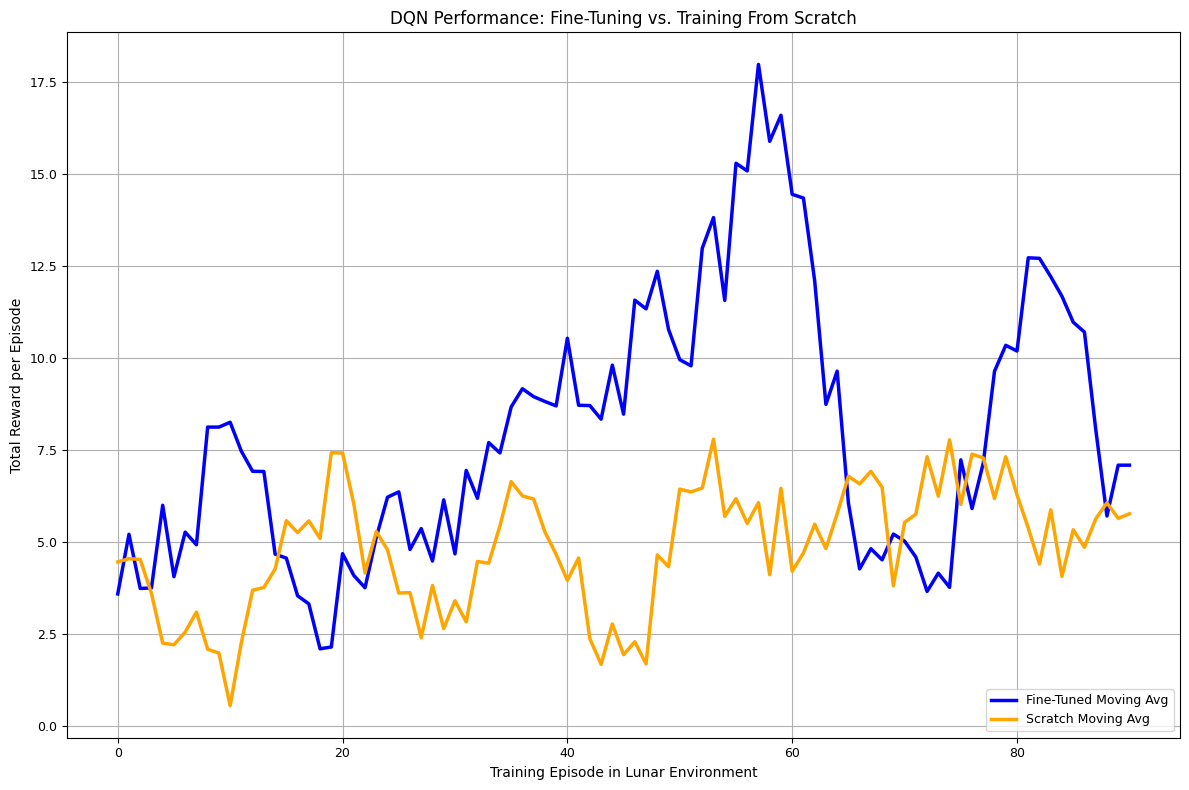


--- Final Performance Summary ---
Avg reward of fine-tuned agent (last 20% eps): 8.64
Avg reward of from-scratch agent (last 20% eps): 6.03


In [3]:
# === Imports ===
import gymnasium as gym
import traceback
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque, namedtuple
import copy
import os
import matplotlib.pyplot as plt

# BSK Imports
from bsk_rl.sim.world import BasicWorldModel, GroundStationWorldModel
from Basilisk.utilities import simIncludeGravBody, orbitalMotion
from bsk_rl.sats.satellite import Satellite
from bsk_rl.obs.observations import SatProperties, Eclipse, Time
from bsk_rl.act.discrete_actions import Scan, Charge, Downlink, Desat
from bsk_rl.sim.fsw import ContinuousImagingFSWModel
from bsk_rl.data import ScanningTimeReward
from bsk_rl.sim import dyn
from bsk_rl.utils.functional import default_args
from bsk_rl import GeneralSatelliteTasking, scene, sats, obs

# === Hyperparameters ===
NUM_FINETUNE_EPISODES = 100
# More episodes to see a clearer learning trend
INNER_BATCH_SIZE = 32
REPLAY_CAPACITY = 10000
TARGET_UPDATE_FREQ = 100
MAX_STEPS_PER_EPISODE = 600
GAMMA = 0.99
TAU = 0.005
# Learning rates and exploration for both agents
FINETUNE_LR = 5e-5               # Fine-tuning often uses a smaller LR
FINETUNE_EPSILON_START = 0.1     # Start with less exploration for a pre-trained model
FINETUNE_EPSILON_END = 0.01
FINETUNE_EPSILON_DECAY = 10000

SCRATCH_LR = 1e-4                # Standard LR for training from scratch
SCRATCH_EPSILON_START = 1.0      # Full exploration for a new agent
SCRATCH_EPSILON_END = 0.02
SCRATCH_EPSILON_DECAY = 15000

NUM_EVAL_EPISODES = 50
LEO_AVG_PERIOD = 5700
LUNAR_AVG_PERIOD = 7200
DURATION = 5 * LUNAR_AVG_PERIOD
PENALTY = -5
REWARD = 1.0 / (DURATION / 100)
DQN_MODEL_PATH = "dqn_leo_fixed_250eps.pth" # Path to your saved DQN model

# === Universal Satellite & Environment Definition ===
# NOTE: The satellite and environment classes are identical to your provided script,
# so they are included here without modification for completeness.

class LEODynamicsModel(dyn.ContinuousImagingDynModel, dyn.GroundStationDynModel):
    @property
    def instrument_pointing_error(self) -> float:
        if np.linalg.norm(self.r_BN_P) < 1e-6:
            return np.pi
        r_BN_P_unit = self.r_BN_P / np.linalg.norm(self.r_BN_P)
        c_hat_P = self.satellite.fsw.c_hat_P
        dot_prod = np.dot(-r_BN_P_unit, c_hat_P)
        return np.arccos(np.clip(dot_prod, -1.0, 1.0))

    @property
    def solar_pointing_error(self) -> float:
        sun_msg = self.world.gravFactory.spiceObject.planetStateOutMsgs[self.world.sun_index].read()
        a_vec = sun_msg.PositionVector
        if np.linalg.norm(a_vec) < 1e-6:
            return np.pi
        a_hat_N = a_vec / np.linalg.norm(a_vec)
        NB = np.transpose(self.BN)
        nHat_N = NB @ self.satellite.sat_args["nHat_B"]
        dot_prod = np.dot(nHat_N, a_hat_N)
        return np.arccos(np.clip(dot_prod, -1.0, 1.0))

class MetaScanningSatellite(sats.AccessSatellite):
    observation_spec = [
        SatProperties(
            dict(prop="storage_level_fraction"),
            dict(prop="battery_charge_fraction"),
            dict(prop="wheel_speeds_fraction"),
            dict(prop="instrument_pointing_error", norm=np.pi),
            dict(prop="solar_pointing_error", norm=np.pi)
        ),
        obs.OpportunityProperties(
            dict(prop="opportunity_open", norm=LUNAR_AVG_PERIOD), # Use Lunar period for normalization
            dict(prop="opportunity_close", norm=LUNAR_AVG_PERIOD),
            type="ground_station",
            n_ahead_observe=1,
        ),
        Eclipse(norm=LUNAR_AVG_PERIOD),
        Time()
    ]
    action_spec = [Scan(180.0), Charge(120.0), Downlink(60.0), Desat(60.0)]
    dyn_type = LEODynamicsModel
    fsw_type = ContinuousImagingFSWModel

def get_default_satellite_hardware_args():
    return {
        "dataStorageCapacity": 10000 * 8e6,
        "storageInit": lambda: np.random.uniform(0.2, 0.6) * (10000 * 8e6),
        "instrumentBaudRate": 0.5 * 8e6,
        "transmitterBaudRate": -50 * 8e6,
        "batteryStorageCapacity": 400 * 3600,
        "storedCharge_Init": lambda: np.random.uniform(0.3, 1.0) * (200 * 3600),
        "basePowerDraw": -10.0,
        "instrumentPowerDraw": -30.0,
        "transmitterPowerDraw": -25.0,
        "thrusterPowerDraw": -80.0,
        "panelArea": 0.35,
        "imageAttErrorRequirement": np.deg2rad(0.1),
        "imageRateErrorRequirement": np.deg2rad(0.1),
        "disturbance_vector": lambda: np.random.normal(scale=0.0001, size=3),
        "maxWheelSpeed": 6000.0,
        "wheelSpeeds": lambda: np.random.uniform(-3000, 3000, 3),
        "desatAttitude": "nadir",
        "nHat_B": np.array([0.0, 0.0, 1.0]),
    }

def get_lunar_env():
    hardware_args = get_default_satellite_hardware_args()
    lunar_orbit = { "a": orbitalMotion.REQ_MOON + 100, "e": 0.0, "i": 45.0, "Omega": 0.0, "omega": 0.0, "f": 0.0, "mu": orbitalMotion.MU_MOON }
    elements_obj = orbitalMotion.ClassicElements()
    elements_obj.a = lunar_orbit["a"] * 1000
    elements_obj.e = lunar_orbit["e"]
    elements_obj.i = np.deg2rad(lunar_orbit["i"])
    elements_obj.Omega = np.deg2rad(lunar_orbit["Omega"])
    elements_obj.omega = np.deg2rad(lunar_orbit["omega"])
    elements_obj.f = np.deg2rad(lunar_orbit["f"])
    hardware_args.update({ "oe": elements_obj, "mu": lunar_orbit["mu"] * 1e9 })
    sat = MetaScanningSatellite("LunarSat", sat_args=hardware_args)
    return GeneralSatelliteTasking(
        satellites=[sat], world_args=dict(utc_init="2025 JAN 01 00:00:00.0 (UTC)"),
        scenario=scene.UniformNadirScanning(value_per_second=REWARD),
        rewarder=ScanningTimeReward(), sim_rate=1.0, max_step_duration=600.0, time_limit=DURATION,
        failure_penalty=PENALTY, terminate_on_time_limit=True, log_level="CRITICAL"
    )

# === DQN, Replay Buffer, and Agent Runner ===
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class SimpleReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

class DQNNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, output_dim)
    def forward(self, x):
        if x.ndim == 3: x = x.squeeze(1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

class DQNAgent:
    def __init__(self, n_observations, n_actions, **kwargs):
        self.n_actions = n_actions
        self.n_observations = n_observations
        self.gamma = kwargs.get("gamma", 0.99)
        self.tau = kwargs.get("tau", 0.005)
        self.policy_net = DQNNetwork(n_observations, n_actions)
        self.target_net = DQNNetwork(n_observations, n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=kwargs.get("learning_rate", 1e-4), amsgrad=True)
        self.epsilon_start = kwargs.get("epsilon_start", 1.0)
        self.epsilon_end = kwargs.get("epsilon_end", 0.02)
        self.epsilon_decay = kwargs.get("epsilon_decay", 10000)
        self.steps_done = 0

    def select_action(self, state, evaluation_mode=False):
        eps_threshold = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * np.exp(-1. * self.steps_done / self.epsilon_decay)
        if not evaluation_mode:
            self.steps_done += 1
        if evaluation_mode or random.random() > eps_threshold:
            with torch.no_grad():
                state_tensor = torch.tensor(np.array(state, dtype=np.float32)).unsqueeze(0)
                return self.policy_net(state_tensor).max(1)[1].item()
        else:
            return random.randrange(self.n_actions)

    def learn(self, replay_buffer, batch_size):
        if len(replay_buffer) < batch_size: return None
        transitions = replay_buffer.sample(batch_size)
        batch = Transition(*zip(*transitions))

        # --- FIX: Check if there are any non-terminal states before stacking ---
        non_final_next_states_list = [s for s in batch.next_state if s is not None]
        if not non_final_next_states_list:
            # This batch contains only terminal states, nothing to learn for next_state_values
            return None # Or handle loss calculation without next_state_values

        # Proceed as before if we have non-terminal states
        state_batch = torch.stack([torch.tensor(s, dtype=torch.float32) for s in batch.state])
        action_batch = torch.tensor(batch.action, dtype=torch.long).view(-1, 1)
        reward_batch = torch.tensor(batch.reward, dtype=torch.float32)
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
        non_final_next_states = torch.stack([torch.tensor(s, dtype=torch.float32) for s in non_final_next_states_list])
        
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(batch_size)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch
        loss = nn.SmoothL1Loss()(state_action_values, expected_state_action_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        
        return loss.item()
        
    def update_target_network(self):
        target_net_state_dict, policy_net_state_dict = self.target_net.state_dict(), self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * self.tau + target_net_state_dict[key] * (1 - self.tau)
        self.target_net.load_state_dict(target_net_state_dict)

    def load_policy(self, path):
        if os.path.exists(path):
            self.policy_net.load_state_dict(torch.load(path))
            self.target_net.load_state_dict(self.policy_net.state_dict())
            print(f"✅ Policy loaded from {path}")
        else:
            raise FileNotFoundError(f"Policy file not found at {path}")

def run_training_loop(env, agent, num_episodes, is_finetune=False):
    """A generic function to run a training/fine-tuning loop for an agent."""
    replay_buffer = SimpleReplayBuffer(REPLAY_CAPACITY)
    all_rewards = []
    print(f"\n--- Starting {'Fine-Tuning' if is_finetune else 'Training From Scratch'} for {num_episodes} episodes... ---")

    for episode in range(num_episodes):
        state, _ = env.reset()
        state = np.array(state[0]).flatten()
        episode_reward = 0
        
        for step in range(MAX_STEPS_PER_EPISODE):
            action = agent.select_action(state)
            next_obs, reward, terminated, truncated, _ = env.step([action])
            done = terminated or truncated
            next_state = None if done else np.array(next_obs[0]).flatten()
            replay_buffer.push(state, action, next_state, reward, float(done))
            state = next_state
            episode_reward += reward
            loss = agent.learn(replay_buffer, INNER_BATCH_SIZE)
            if agent.steps_done % TARGET_UPDATE_FREQ == 0:
                agent.update_target_network()
            if done: break
        
        all_rewards.append(episode_reward)
        if (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1}/{num_episodes} | Avg Reward (last 10): {np.mean(all_rewards[-10:]):.2f}")
    
    return all_rewards

# === Main Execution Block ===
if __name__ == "__main__":
    # --- Step 1: Setup Environment and Agents ---
    print("Setting up Lunar environment...")
    lunar_env = get_lunar_env()
    state, _ = lunar_env.reset()
    n_observations = np.array(state[0]).flatten().shape[0]
    n_actions = lunar_env.satellites[0].action_space.n
    print(f"Lunar Environment: Obs Dim={n_observations}, Act Dim={n_actions}")

    # Agent 1: Pre-trained and ready for fine-tuning
    finetune_agent = DQNAgent(
        n_observations, n_actions,
        learning_rate=FINETUNE_LR, gamma=GAMMA, tau=TAU,
        epsilon_start=FINETUNE_EPSILON_START, epsilon_end=FINETUNE_EPSILON_END,
        epsilon_decay=FINETUNE_EPSILON_DECAY
    )
    print(f"\nLoading pre-trained LEO policy from {DQN_MODEL_PATH}...")
    finetune_agent.load_policy(DQN_MODEL_PATH)
    
    # Agent 2: New agent to be trained from scratch
    scratch_agent = DQNAgent(
        n_observations, n_actions,
        learning_rate=SCRATCH_LR, gamma=GAMMA, tau=TAU,
        epsilon_start=SCRATCH_EPSILON_START, epsilon_end=SCRATCH_EPSILON_END,
        epsilon_decay=SCRATCH_EPSILON_DECAY
    )

    # --- Step 2: Run Both Training Loops ---
    finetune_rewards = run_training_loop(lunar_env, finetune_agent, NUM_FINETUNE_EPISODES, is_finetune=True)
    scratch_rewards = run_training_loop(lunar_env, scratch_agent, NUM_FINETUNE_EPISODES, is_finetune=False)
    
    # --- Step 3: Plotting and Comparison ---
    print("\n--- Plotting Results ---")
    def moving_average(data, window_size=10):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    plt.figure(figsize=(12, 8))
    
    # Plot moving averages
    plt.plot(moving_average(finetune_rewards), 'b-', label='Fine-Tuned Moving Avg', linewidth=2.5)
    plt.plot(moving_average(scratch_rewards), 'orange', label='Scratch Moving Avg', linewidth=2.5)
    
    plt.title("DQN Performance: Fine-Tuning vs. Training From Scratch")
    plt.xlabel("Training Episode in Lunar Environment")
    plt.ylabel("Total Reward per Episode")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("dqn_finetune_vs_scratch_analysis.png")
    plt.show()

    print("\n--- Final Performance Summary ---")
    # Compare the performance over the last 20% of episodes
    final_finetune_avg = np.mean(finetune_rewards[-int(NUM_FINETUNE_EPISODES*0.2):])
    final_scratch_avg = np.mean(scratch_rewards[-int(NUM_FINETUNE_EPISODES*0.2):])
    
    print(f"Avg reward of fine-tuned agent (last 20% eps): {final_finetune_avg:.2f}")
    print(f"Avg reward of from-scratch agent (last 20% eps): {final_scratch_avg:.2f}")

    lunar_env.close()